In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [82]:
#Membaca dataset
dt = pd.read_excel("dataset1.xlsx")

dt.head()

,Pengirim,Layanan,Sumber,Biaya,Status
0,17,1,7,374962,8
1,62,1,7,211860,8
2,31,1,7,174982,5
3,15,2,6,110000,8
4,123,2,6,105000,5


In [83]:
#Pengecekan data kosong
dt.isna().sum()

Pengirim    0
Layanan     0
Sumber      0
Biaya       0
Status      0
dtype: int64

In [84]:
#Melihat Tipe Dataset
data_types = dt.dtypes

# Print data types
print(data_types)

Pengirim    int64
Layanan     int64
Sumber      int64
Biaya       int64
Status      int64
dtype: object


In [86]:
# Preprocessing data
X = dt[['Pengirim', 'Layanan', 'Sumber', 'Biaya']]
y = dt['Status']

# Bagi data menjadi data latih dan data uji 80 dan 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [87]:
# Inisialisasi model KNN
model = KNeighborsClassifier()

# Latih model menggunakan data latih
model.fit(X_train, y_train)

# Lakukan prediksi harga telur menggunakan data uji
y_pred = model.predict(X_test)

# Evaluasi model menggunakan metode R^2
r2_score = model.score(X_test, y_test)
print('Nilai R2:', r2_score, '%')


Nilai R2: 0.6535836177474402 %


In [88]:
# Contoh prediksi paket dengan data baru
#dt[['Pengirim', 'Layanan', 'Pembayaran', 'Sumber', 'Biaya']]
data_baru = pd.DataFrame({
    'Pengirim': [42],
    'Layanan': [2],
    'Sumber': [6],
    'Biaya': [4365]
})

status_prediksi = model.predict(data_baru)
print('Prediksi Status Paket:', status_prediksi)

Prediksi Status Paket: [9]


In [90]:
#Menyimpan model ML
import pickle
filename = 'finalized_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [97]:
# Contoh prediksi paket dengan data baru
model1 = pickle.load( open( "finalized_model.pkl", "rb" ))
data_baru = pd.DataFrame({
    'Pengirim': [8],
    'Layanan': [1],
    'Sumber': [2],
    'Biaya': [4678]
})

status_prediksi = model1.predict(data_baru)
print('Prediksi Status Paket:', status_prediksi)

Prediksi Status Paket: [9]


In [ ]:
from flask import Flask, jsonify, make_response, request, render_template, abort, redirect, url_for, session
import pandas as pd
import numpy as np
import pickle
import mysql.connector
import re

from flask_cors import CORS,cross_origin
model = pickle.load( open( "finalized_model.pkl", "rb" ) )
app = Flask(__name__)
app.config['CORS_HEADERS'] = 'Content-Type'
app.secret_key = 'MIFTAHCCIT1234'

#Koneksi Database
conn = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="",
  database="package_prediction"
    
)
#Buat Kursor (Penunjuk)
cursor = conn.cursor()

#Cek Koneksi Berhasil ?
if conn.is_connected():
  print("Berhasil terhubung ke database")

#Error Page
cors = CORS(app)
@app.errorhandler(404)
def not_found(error):
    return make_response(jsonify({'error': 'Not found'}), 404)

#Halaman Pertama Kali
@app.route("/")
def index():
   return render_template('login.html')

#Halaman Utama / Home
@app.route("/home")
def home():
    # Check if user is loggedin
    if 'loggedin' in session:
        # User is loggedin show them the home page
        return render_template('home.html', username=session['username'])
    # User is not loggedin redirect to login page
    return redirect(url_for('login'))

#Menu Profile
@app.route('/predict')
def predict():
    if 'loggedin' in session:
        return render_template('index.html')
    else :
        return render_template('login.html')

#Fungsi Cek Login
@app.route("/login", methods=['GET', 'POST', 'OPTIONS'])
def login():
    # Output message if something goes wrong...
    msg = ''
    # Check if "username" and "password" POST requests exist (user submitted form)
    if request.method == 'POST' and 'username' in request.form and 'password' in request.form:
        # Create variables for easy access
        username = request.form['username']
        password = request.form['password']
        # Check if account exists using MySQL
        cursor.execute('SELECT * FROM accounts WHERE username = %s AND password = %s', (username, password,))
        # Fetch one record and return result
        account = cursor.fetchone()
        # If account exists in accounts table in out database
        if account:
            # Create session data, we can access this data in other routes
            session['loggedin'] = True
            session['username'] = username
            # Redirect to home page
            return render_template('home.html', msg=session['username'])
        else:
            # Account doesnt exist or username/password incorrect
            msg = 'Incorrect username/password!'
    # Show the login form with message (if any)
    return render_template('login.html', msg=msg)

#Fungsi Logout
@app.route("/logout")
def logout():
    # Remove session data, this will log the user out
   session.pop('loggedin', None)
   session.pop('id', None)
   session.pop('username', None)
   # Redirect to login page
   return render_template('login.html')

@app.route("/register", methods=['GET', 'POST'])
def register():
    # Output message if something goes wrong...
    msg = ''
    # Check if "username", "password" and "email" POST requests exist (user submitted form)
    if request.method == 'POST' and 'loggedin' not in session and 'username' in request.form and 'password' in request.form and 'email' in request.form:
        # Create variables for easy access
        username = request.form['username']
        password = request.form['password']
        email = request.form['email']
        cursor.execute('SELECT * FROM accounts WHERE username = %s', (username,))
        account = cursor.fetchone()
        # If account exists show error and validation checks
        if account:
            msg = 'Account already exists!'
        elif not re.match(r'[^@]+@[^@]+\.[^@]+', email):
            msg = 'Invalid email address!'
        elif not re.match(r'[A-Za-z0-9]+', username):
            msg = 'Username must contain only characters and numbers!'
        elif not username or not password or not email:
            msg = 'Please fill out the form!'
        else:
            # Account doesnt exists and the form data is valid, now insert new account into accounts table
            cursor.execute('INSERT INTO accounts VALUES (NULL, %s, %s, %s)', (username, password, email,))
            conn.commit()
            msg = 'You have successfully registered!'
            # Redirect to home page
            return render_template('login.html', msg=msg)
    elif request.method == 'POST':
        # Form is empty... (no POST data)
        msg = 'Please fill out the form!'
    # Show registration form with message (if any)
    return render_template('register.html', msg=msg)

#Konversi ke Rupiah
def transform_to_rupiah_format(value):
    str_value = str(value)
    separate_decimal = str_value.split(".")
    after_decimal = separate_decimal[0]
    before_decimal = separate_decimal[1]

    reverse = after_decimal[::-1]
    temp_reverse_value = ""

    for index, val in enumerate(reverse):
        if (index + 1) % 3 == 0 and index + 1 != len(reverse):
            temp_reverse_value = temp_reverse_value + val + "."
        else:
            temp_reverse_value = temp_reverse_value + val

    temp_result = temp_reverse_value[::-1]

    return "Rp " + temp_result

#Prediksi Data
@app.route("/get_prediction", methods=['POST','OPTIONS'])
@cross_origin()
def get_prediction():
    if request.method == 'POST' and 'loggedin' in session and 'pengirim' in request.form  and 'layanan' in request.form and 'pembayaran' in request.form and 'sumber' in request.form and 'biaya' in request.form :
        #Mengambil 3 Karakter Angka
        string = request.form['pengirim']
        
        pengirim = int(string[0: 3])
        layanan = request.form['layanan']
        pembayaran = request.form['pembayaran']
        sumber = request.form['sumber']
        biaya = request.form['biaya']
        x = biaya.replace("Rp. ", "")
        biaya = x.replace(".", "")
        
        #Prediksi Data
        data_prediksi = pd.DataFrame({
            'Pengirim': [pengirim],
            'Layanan': [layanan],
            'Pembayaran': [pembayaran],
            'Sumber': [sumber],
            'Biaya': [biaya]
        })

        hasil_prediksi = model.predict(data_prediksi)
        if hasil_prediksi == 1 :
            hasil = "SUCCESS"
            return render_template('index.html',prediction_text="Package Prediction : {} ".format(hasil))
        else:
            hasil = "FAILED"
            return render_template('index.html',prediction_text="Package Prediction : {} ".format(hasil))          
    else:
        return render_template('index.html')
    
if __name__ == "__main__":
  app.run()

Berhasil terhubung ke database
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [31/Jul/2023 00:07:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2023 00:07:09] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [31/Jul/2023 00:07:09] "GET /static/bri.png HTTP/1.1" 304 -
127.0.0.1 - - [31/Jul/2023 00:07:19] "POST /login HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2023 00:07:20] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [31/Jul/2023 00:07:20] "GET /static/loan.jpg HTTP/1.1" 304 -
127.0.0.1 - - [31/Jul/2023 00:07:35] "GET /predict HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2023 00:07:35] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [31/Jul/2023 00:07:35] "GET /js/login.js HTTP/1.1" 404 -
127.0.0.1 - - [31/Jul/2023 00:07:56] "POST /get_prediction HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2023 00:07:56] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [31/Jul/2023 00:07:56] "GET /js/login.js HTTP/1.1" 404 -
127.0.0.1 - - [31/Jul/2023 00:08:22] "POST /get_prediction HTTP/1.1" 200 -
127.0

In [23]:
string = "001-Shabani Official"
first_characters = int(string[0: 3])
print("First 3 characters:", first_characters)

First 3 characters: 1


In [6]:
import pandas as pd

# Load the data from the Excel file
excel_file = 'dataset.xlsx'
data = pd.read_excel(excel_file)

# Display the first few rows of the data
print(data.head())

   Pengirim  Layanan  Pembayaran  Sumber   Biaya  Status
0        17        1           1       7  374962       8
1        62        1           1       7  211860       8
2        31        1           1       7  174982       5
3        15        2           1       6  110000       8
4       123        2           1       6  105000       5


In [7]:
from sklearn.cluster import KMeans

# Select the features for clustering
features = data[['Pengirim', 'Layanan', 'Pembayaran', 'Sumber', 'Biaya', 'Status']]  # Replace 'Feature1' and 'Feature2' with your column names

# Create KMeans instance
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)

# Fit and predict
labels = kmeans.fit_predict(features)

C:\Users\Commander\opencv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
#=IF(L2="Other";1;IF(L2="Delivery";2;IF(L2="Kirim";3;IF(L2="Pack";4;IF(L2="Paket Bermasalah";5;IF(L2="Paket Tinggal Gudang";6;IF(L2="Sampai";7;IF(L2="Tanda Terima";8;IF(L2="TTD Retur";9;0)))))))))

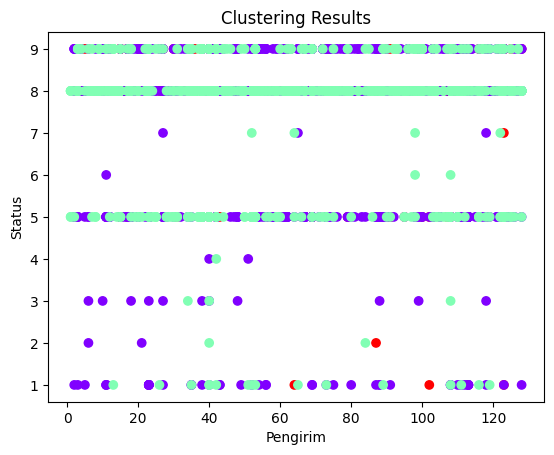

In [9]:
import matplotlib.pyplot as plt

# Add the cluster labels as a new column in the data
data['Cluster'] = labels

# Plot the data points with different colors for each cluster
plt.scatter(data['Pengirim'], data['Status'], c=data['Cluster'], cmap='rainbow')
plt.xlabel('Pengirim')
plt.ylabel('Status')
plt.title('Clustering Results')
plt.show()

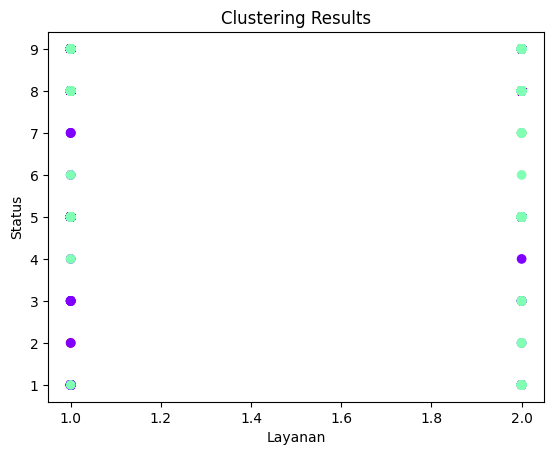

In [10]:
import matplotlib.pyplot as plt

# Add the cluster labels as a new column in the data
data['Cluster'] = labels

#features = data[['Pengirim', 'Layanan', 'Pembayaran', 'Sumber', 'Biaya', 'Status']] 
# Plot the data points with different colors for each cluster
plt.scatter(data['Layanan'], data['Status'], c=data['Cluster'], cmap='rainbow')
plt.xlabel('Layanan')
plt.ylabel('Status')
plt.title('Clustering Results')
plt.show()

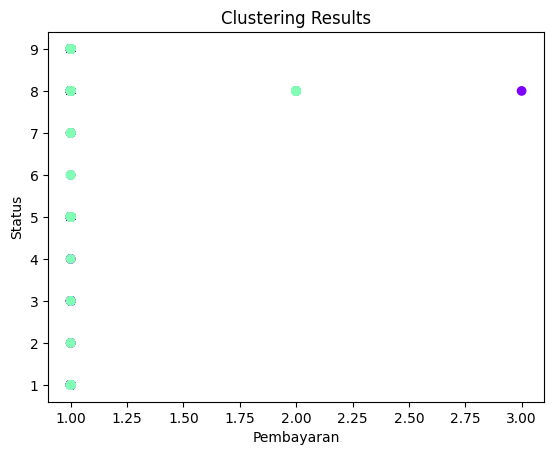

In [11]:
import matplotlib.pyplot as plt

# Add the cluster labels as a new column in the data
data['Cluster'] = labels

#features = data[['Pengirim', 'Layanan', 'Pembayaran', 'Sumber', 'Biaya', 'Status']] 
# Plot the data points with different colors for each cluster
plt.scatter(data['Pembayaran'], data['Status'], c=data['Cluster'], cmap='rainbow')
plt.xlabel('Pembayaran')
plt.ylabel('Status')
plt.title('Clustering Results')
plt.show()

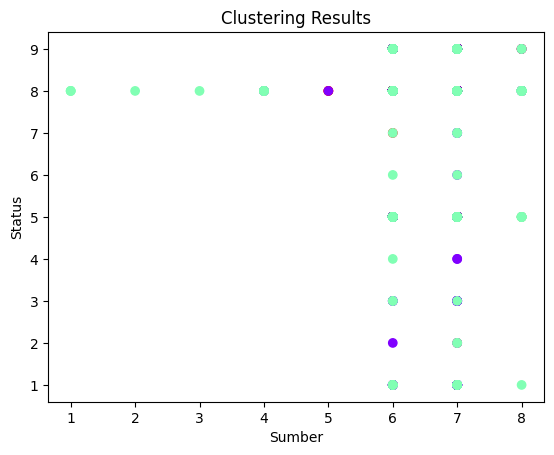

In [12]:
import matplotlib.pyplot as plt

# Add the cluster labels as a new column in the data
data['Cluster'] = labels

#features = data[['Pengirim', 'Layanan', 'Pembayaran', 'Sumber', 'Biaya', 'Status']] 
# Plot the data points with different colors for each cluster
plt.scatter(data['Sumber'], data['Status'], c=data['Cluster'], cmap='rainbow')
plt.xlabel('Sumber')
plt.ylabel('Status')
plt.title('Clustering Results')
plt.show()

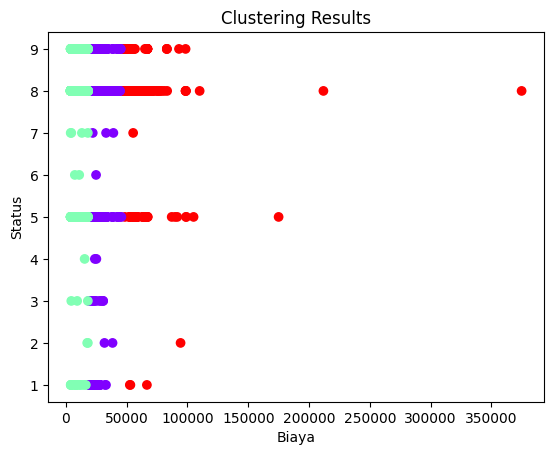

In [13]:
import matplotlib.pyplot as plt

# Add the cluster labels as a new column in the data
data['Cluster'] = labels

#features = data[['Pengirim', 'Layanan', 'Pembayaran', 'Sumber', 'Biaya', 'Status']] 
# Plot the data points with different colors for each cluster
plt.scatter(data['Biaya'], data['Status'], c=data['Cluster'], cmap='rainbow')
plt.xlabel('Biaya')
plt.ylabel('Status')
plt.title('Clustering Results')
plt.show()

In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
%matplotlib inline

In [53]:
import pandas as pd

# Load the data from the Excel file
excel_file = 'dataset1.xlsx'
df = pd.read_excel(excel_file)

# Display the first few rows of the data
print(data.head())

   Pengirim  Layanan  Pembayaran  Sumber   Biaya  Status
0        17        1           1       7  374962       8
1        62        1           1       7  211860       8
2        31        1           1       7  174982       5
3        15        2           1       6  110000       8
4       123        2           1       6  105000       5


In [54]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2926 entries, 0 to 2925
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Pengirim  2926 non-null   int64
 1   Layanan   2926 non-null   int64
 2   Sumber    2926 non-null   int64
 3   Biaya     2926 non-null   int64
 4   Status    2926 non-null   int64
dtypes: int64(5)
memory usage: 114.4 KB


In [55]:
df.isnull().sum()

Pengirim    0
Layanan     0
Sumber      0
Biaya       0
Status      0
dtype: int64

In [56]:
df.describe()

,Pengirim,Layanan,Sumber,Biaya,Status
count,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000
mean,61.575871,1.552973,6.619959,23000.517088,7.560150
std,37.452879,0.497271,0.572711,16298.792519,1.590024
min,1.000000,1.000000,1.000000,3880.000000,1.000000
25%,24.000000,1.000000,6.000000,13095.000000,8.000000
50%,59.000000,2.000000,7.000000,22028.000000,8.000000
75%,96.000000,2.000000,7.000000,28710.000000,8.000000
max,128.000000,2.000000,8.000000,374962.000000,9.000000


In [57]:
df['Status'].unique()

array([8, 5, 9, 2, 1, 7, 3, 4, 6], dtype=int64)

In [58]:
# view how many different types of variables are there

len(df['Status'].unique())

9

In [59]:
X = df

y = df['Status']

In [60]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X['Status'] = le.fit_transform(X['Status'])

y = le.transform(y)

In [61]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2926 entries, 0 to 2925
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Pengirim  2926 non-null   int64
 1   Layanan   2926 non-null   int64
 2   Sumber    2926 non-null   int64
 3   Biaya     2926 non-null   int64
 4   Status    2926 non-null   int64
dtypes: int64(5)
memory usage: 114.4 KB


In [62]:
cols = X.columns
from sklearn.preprocessing import MinMaxScaler

ms = MinMaxScaler()

X = ms.fit_transform(X)
X = pd.DataFrame(X, columns=[cols])
X.head()

,Pengirim,Layanan,Sumber,Biaya,Status
0,0.125984,0.0,0.857143,1.000000,0.875
1,0.480315,0.0,0.857143,0.560469,0.875
2,0.236220,0.0,0.857143,0.461089,0.500
3,0.110236,1.0,0.714286,0.285975,0.875
4,0.960630,1.0,0.714286,0.272500,0.500


In [63]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0) 

kmeans.fit(X)

C:\Users\Commander\opencv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=0)

In [64]:
kmeans.cluster_centers_

array([[ 2.69935273e-01,  1.00000000e+00,  7.77845036e-01,
         4.16995583e-02,  8.29316737e-01],
       [ 2.04915741e-01,  1.55431223e-15,  8.34979973e-01,
         6.17315255e-02,  9.02570093e-01],
       [ 8.17799481e-01,  1.00000000e+00,  7.74904621e-01,
         4.70039039e-02,  8.24740356e-01],
       [ 7.02683761e-01,  7.77156117e-16,  8.36699078e-01,
         5.99669889e-02,  8.69109948e-01],
       [ 3.86732283e-01, -6.66133815e-16,  8.32142857e-01,
         6.16688091e-02,  3.98750000e-01]])

In [65]:
kmeans.inertia_

162.63898936180956

In [66]:
labels = kmeans.labels_

# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 170 out of 2926 samples were correctly labeled.
Accuracy score: 0.06


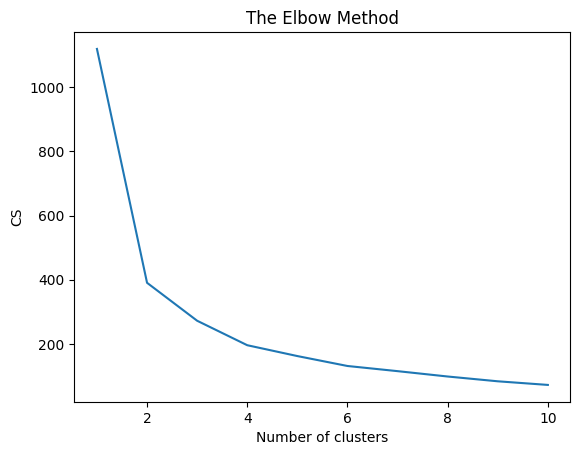

In [67]:
from sklearn.cluster import KMeans
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [79]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=30,random_state=0)

kmeans.fit(X)

labels = kmeans.labels_

# check how many of the samples were correctly labeled

correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

C:\Users\Commander\opencv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Result: 85 out of 2926 samples were correctly labeled.
Accuracy score: 0.03


In [37]:
kmeans = KMeans(n_clusters=3, random_state=0)

kmeans.fit(X)

# check how many of the samples were correctly labeled
labels = kmeans.labels_

correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 17 out of 2926 samples were correctly labeled.
Accuracy score: 0.01


C:\Users\Commander\opencv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [45]:
kmeans = KMeans(n_clusters=12, random_state=0)

kmeans.fit(X)

# check how many of the samples were correctly labeled
labels = kmeans.labels_

correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 93 out of 2926 samples were correctly labeled.
Accuracy score: 0.03


C:\Users\Commander\opencv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
